In [1]:
from pyspark.sql import DataFrame
from graphframes import graphframe
from pyspark.shell import spark

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.5.0
      /_/

Using Python version 3.11.6 (main, Oct  3 2023 10:40:35)
Spark context Web UI available at http://c23eaf907387:4040
Spark context available as 'sc' (master = local[*], app id = local-1732878644575).
SparkSession available as 'spark'.


In [2]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

### 1
Wczytać graf Facebooka, krawędzie z pliku musae_facebook_edges.csv, atrybuty page_name oraz page_type z pliku musae_facebook_target.csv.  Policzyć liczbę krawędzi i wierzchołków. (1 p.)

In [3]:
from graphframes import *

vertices_df = spark.read.option("header", True).csv(
    "facebook_large/musae_facebook_target.csv"
)

edges_df = spark.read.option("header", True).csv(
    "facebook_large/musae_facebook_edges.csv"
)
edges_df = edges_df.withColumnRenamed("id_1", "src").withColumnRenamed("id_2", "dst")

g = GraphFrame(vertices_df, edges_df)

In [4]:
g.vertices.count()

22470

In [5]:
g.edges.count()

171002

### 2
Sprawdzić czy graf jest spójny. Czy dwa podgrafy utworzone dla typów strony governmental organizations oraz television shows też są spójne? (1 p.)

In [6]:
sc.setCheckpointDir("/tmp/graphframes-example-connected-components")
g.connectedComponents().groupby("component").count().show()

+---------+-----+
|component|count|
+---------+-----+
|        0|22470|
+---------+-----+



### 3
Spośród 1000 stron o najwyższym PageRank znaleźć 50 takich (wypisać page_name i page_type), które mają najmniej połączeń oraz 50 o największej liczbie połączeń. Który typ strony był dominujący w każdej z tych kategorii? Narysować wykres zależności PageRank od liczby krawędzi dla wierzchołków (scatter plot) (2 p.)

In [7]:
results = g.pageRank(maxIter=10)
top_1k_pagerank = results.vertices.orderBy("pageRank", ascending=False).limit(1000)

In [8]:
top_1k_pagerank.show(3)

+-----+---------------+--------------------+----------+------------------+
|   id|    facebook_id|           page_name| page_type|          pagerank|
+-----+---------------+--------------------+----------+------------------+
|21729|    63811549237|The Obama White H...|government|119.30838334728563|
|22208|     9229303148|U.S. Department o...|government| 68.13255237491354|
|21781|101690176567548|           Microsoft|   company|56.407039625973916|
+-----+---------------+--------------------+----------+------------------+
only showing top 3 rows



In [9]:
results.edges.count()

171002

In [10]:
from pyspark.sql.functions import col
from functools import reduce
from operator import add

id_only = top_1k_pagerank.select("id")

edges_in = (
    g.edges.join(id_only, g.edges.dst == id_only.id, "inner")
    .select("dst")
    .groupBy("dst")
    .count()
    .withColumnRenamed("count", "in_deg")
    .withColumnRenamed("dst", "id1")
)

edges_out = (
    g.edges.join(id_only, g.edges.src == id_only.id, "inner")
    .select("src")
    .groupBy("src")
    .count()
    .withColumnRenamed("count", "out_deg")
    .withColumnRenamed("src", "id2")
)

combined = (
    edges_out.join(edges_in, edges_out.id2 == edges_in.id1, "inner")
    .withColumnRenamed("id1", "v_id")
    .withColumn("total_edges", reduce(add, [col("in_deg"), col("out_deg")]))
    .select("v_id", "total_edges")
)

In [11]:
top_1k = (
    top_1k_pagerank.join(combined, combined.v_id == top_1k_pagerank.id)
    .select("id", "page_name", "page_type", "pagerank", "total_edges")
    .orderBy("total_edges", ascending=False)
)

In [12]:
top_1k_most_edges = top_1k.limit(50)

top_1k_least_edges = top_1k.orderBy("total_edges").limit(50)

In [13]:
top_1k_most_edges.groupby("page_type").count().show()

+----------+-----+
| page_type|count|
+----------+-----+
|government|   38|
|politician|   10|
|   company|    2|
+----------+-----+



In [14]:
top_1k_least_edges.groupby("page_type").count().show()

+----------+-----+
| page_type|count|
+----------+-----+
|   company|   30|
|    tvshow|    5|
|politician|    9|
|government|    6|
+----------+-----+



<Axes: xlabel='pagerank', ylabel='total_edges'>

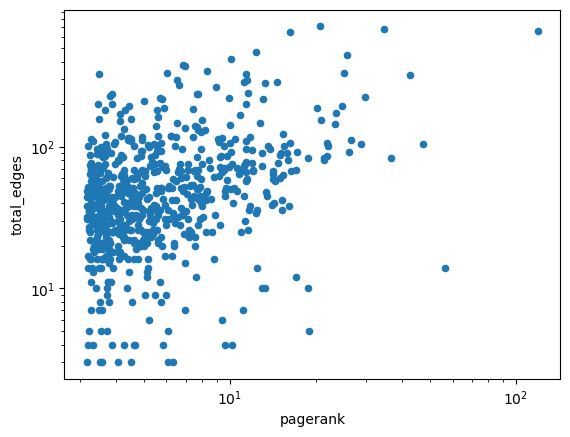

In [15]:
top_1k.toPandas().plot.scatter(x="pagerank", y="total_edges", logx=True, logy=True)

### 4
Korzystając z Pregel API zaimplementować następujący algorytm. W pierwszym kroku wybrana strona publikuje post fake news. W kolejnym kroku ten post publikowany jest przez 1/4 losowo wybranych kontaktów tej strony. W dalszych krokach, dla każdej strony, która opublikowała już ten post, losowo wybrane 1/4 jej kontaktów publikuje go u siebie. Pokazać jak zmienia się liczba stron które opublikowały post w zależności od liczby kroków. (2 p.)
Opcjonalnie: Sprawdzić powyższą zależność dla współczynnika innego niż 1/4.

100%|██████████| 20/20 [01:21<00:00,  4.05s/it]


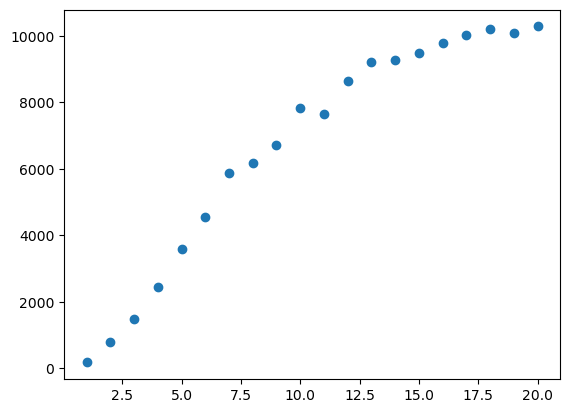

In [16]:
from tqdm import tqdm
from pyspark.sql.functions import when, rand, coalesce, max
from graphframes.lib import Pregel
import matplotlib.pyplot as plt

spark.sparkContext.setCheckpointDir('checkpoints3')

g.vertices.where(col("id")=="21729").collect()

P = 0.25
def reposted(seen) :
    return ((seen > 0).cast("int") * rand() > (1-P)).cast("int")

posted = []
for iterations in tqdm(list(range(1, 21))):
    count = 1
    while count <= 1:
        sim = (g.pregel 
        .setMaxIter(iterations) 
        .withVertexColumn('posted',
                          when(col('id') == '21729', 1).otherwise(0),
                          ((Pregel.msg() + col('posted')) > 0).cast("int"))     
        .sendMsgToSrc(Pregel.dst('posted')) 

               
        .aggMsgs(reposted(max(Pregel.msg()))) 
        .run())

        count = sim.filter(col('posted') == True).count()

    posted.append(count)

plt.scatter(x=list(range(1, 21)), y=posted)

### 5
Narysować wykres rozkładu stopnia wierzchołków w grafie w skali logarytmicznej. Można skorzystać z metody stat.approxQuantile. Czy sieć jest bezskalowa (scale-free)? https://barabasi.com/f/623.pdf  (2 p.)

In [17]:
all_ids = g.vertices.select("id")

edges_in = (
    g.edges.join(all_ids, g.edges.dst == all_ids.id, "inner")
    .select("dst")
    .groupBy("dst")
    .count()
    .withColumnRenamed("count", "in_deg")
    .withColumnRenamed("dst", "id1")
)

edges_out = (
    g.edges.join(all_ids, g.edges.src == all_ids.id, "inner")
    .select("src")
    .groupBy("src")
    .count()
    .withColumnRenamed("count", "out_deg")
    .withColumnRenamed("src", "id2")
)

combined = (
    edges_out.join(edges_in, edges_out.id2 == edges_in.id1, "inner")
    .withColumn("total_deg", reduce(add, [col("in_deg"), col("out_deg")]))
    .select("id1", "in_deg", "out_deg", "total_deg")
    .withColumnRenamed("id1", "id")
)

In [18]:
from pyspark.sql.functions import log

combined = combined.select("total_deg").groupBy("total_deg").count()

In [19]:
combined.show(3)

+---------+-----+
|total_deg|count|
+---------+-----+
|       26|  178|
|       29|  136|
|       65|   21|
+---------+-----+
only showing top 3 rows



<Axes: xlabel='total_deg', ylabel='count'>

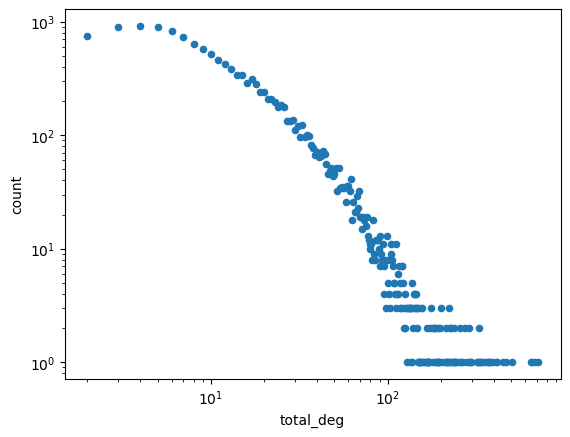

In [20]:
combined.toPandas().plot.scatter(x="total_deg", y="count", logx=True, logy=True)

The points seem to be following a slightly curved line. We can't exactly say that it's scale-free but it's leaning towards it